In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sklearn

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection
from f_selector.feature_selector import FeatureSelector

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from collections import Counter
from sklearn.utils import shuffle


#Кастомные модули
from Data_Preparation import Data_Preparation
from CreditScoreModel import CreditScoreModel
from ROC_metric import ROC_metric

In [2]:
#Загрузка dataset
raw_data = pd.read_pickle('data/data.pickle')

In [3]:
#Описание данных
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041060 entries, 0 to 1041059
Data columns (total 75 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   app_id                         1041060 non-null  int64  
 1   claim_fd                       1041060 non-null  object 
 2   count_days_between_packets     1041060 non-null  float64
 3   count_periods_between_packets  1041060 non-null  int64  
 4   median_days_between_packets    1041060 non-null  float64
 5   mean_days_between_packets      1041060 non-null  float64
 6   variance_days_between_packets  1041060 non-null  float64
 7   months_in_YOTA                 1041060 non-null  int64  
 8   is_mnp                         1041060 non-null  int64  
 9   count_account_id               1041060 non-null  int64  
 10  have_pd                        1041060 non-null  int64  
 11  is_Russia                      1041060 non-null  int64  
 12  is_rus_pasport

In [4]:
#Первые 5 объектов
raw_data.head()

,app_id,claim_fd,count_days_between_packets,count_periods_between_packets,median_days_between_packets,mean_days_between_packets,variance_days_between_packets,months_in_YOTA,is_mnp,count_account_id,...,calls_out_cnt_uniq_opps,calls_in_minutes,calls_out_minutes,calls_in_minutes_mean,calls_out_minutes_mean,calls_in_minutes_median,calls_out_minutes_median,calls_in_minutes_variance,calls_out_minutes_variance,is_bad
0,1,2020-11-04 18:59:13,0.0,0,0.0,0.0,0.0,79,1,2,...,13.0,51.0,44.0,1.21,2.10,1.0,2.0,3.977352,1.890476,0
1,1,2021-02-03 19:02:05,0.0,0,0.0,0.0,0.0,82,1,2,...,18.0,97.0,48.0,1.39,1.55,1.0,1.0,3.370807,1.189247,0
2,9274,2020-10-08 14:01:00,0.0,0,0.0,0.0,0.0,78,0,1,...,23.0,73.0,178.0,1.33,3.36,1.0,1.0,1.150168,26.311321,0
3,274947,2020-10-11 23:45:28,0.0,0,0.0,0.0,0.0,74,0,2,...,67.0,339.0,292.0,1.37,1.72,1.0,1.0,0.986271,2.357675,0
4,274947,2020-12-11 00:05:42,0.0,0,0.0,0.0,0.0,76,0,2,...,58.0,306.0,233.0,1.67,2.06,1.0,2.0,2.913889,2.969343,0


In [5]:
#Процесс кодирования даты
raw_data = shuffle(raw_data)
object_data = raw_data.select_dtypes('object')
numeric_data = raw_data.select_dtypes('number')

#Data Coding
def format_date(date_string):
    d = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    year = str(d.year)
    month = str(d.month)
    return year + month

for idx in range(len(object_data)):
    object_data['claim_fd'][idx] = format_date(object_data['claim_fd'][idx])
object_data['claim_fd'] = object_data['claim_fd'].astype(int)
raw_data['claim_fd'] = object_data['claim_fd']
raw_data.head()

,app_id,claim_fd,count_days_between_packets,count_periods_between_packets,median_days_between_packets,mean_days_between_packets,variance_days_between_packets,months_in_YOTA,is_mnp,count_account_id,...,calls_out_cnt_uniq_opps,calls_in_minutes,calls_out_minutes,calls_in_minutes_mean,calls_out_minutes_mean,calls_in_minutes_median,calls_out_minutes_median,calls_in_minutes_variance,calls_out_minutes_variance,is_bad
180698,6756482,202012,41.0,7,4.0,5.857143,14.476190,54,0,1,...,16.0,57.0,28.0,1.50,1.22,1.0,1.0,1.391892,0.541502,0
421758,12359831,202012,0.0,0,0.0,0.000000,0.000000,40,0,5,...,31.0,139.0,147.0,1.31,1.32,1.0,1.0,1.511680,1.530221,0
123350,5228983,20212,130.0,4,17.5,32.500000,1820.333333,59,0,1,...,2.0,18.0,23.0,2.00,2.88,2.0,3.0,1.500000,3.553571,0
314912,9443091,20211,33.0,3,2.0,11.000000,243.000000,49,0,2,...,11.0,181.0,139.0,1.55,1.81,1.0,1.0,1.767168,2.553657,0
197727,7164763,202010,2.0,1,2.0,2.000000,0.000000,51,0,5,...,23.0,169.0,77.0,1.16,1.08,1.0,1.0,1.099150,0.164185,0


In [6]:
#Список имен признаков
feature_name = list(raw_data.columns)

#Проверка данных на аномалии
check_value = {}
for name in feature_name[:-1]:
    max_ = raw_data[name].max()
    min_ = raw_data[name].min()
    check_value[name] = (min_, max_)
    if min_ < 0: print(f'negative min is: {name}')
    if max_ < 0: print(f'negative max is: {name}')
        
#Очистка данных от некорректных значений
raw_data = raw_data.loc[(raw_data['age_come_YOTA'] > 0) & 
                       (raw_data['sum_payments_0'] >= 0) &
                       (raw_data['sum_payments_1'] >= 0) &
                       (raw_data['sum_payments_part_1'] >= 0) &
                       (raw_data['sum_payments_2'] >= 0) &
                       (raw_data['sum_payments_part_2'] >= 0)]

x_data = raw_data[feature_name[:-1]]
y_data = raw_data[feature_name[-1]]

negative min is: age_come_YOTA
negative min is: sum_payments_0
negative min is: sum_payments_1
negative min is: sum_payments_part_1
negative min is: sum_payments_2
negative min is: sum_payments_part_2


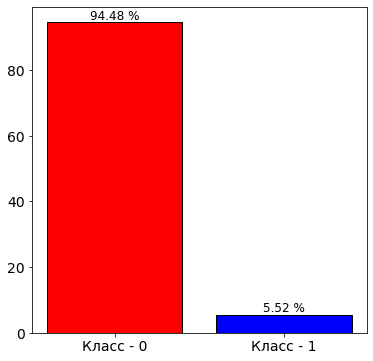

Количество объектов в каждом классе: 
0    982900
1     57434
Name: is_bad, dtype: int64


In [7]:
#Проверка на сбалансированность классов
norm_y_data = y_data.value_counts(normalize=True)
per = 100
x = ['Класс - 0', 'Класс - 1']
y = [norm_y_data[0]*per,norm_y_data[1]*per]
fc = ['red', 'blue']

fig, ax = plt.subplots()
for idx in range(len(x)):
    plt.bar(x[idx], y[idx], fc=fc[idx], ec='black')
    plt.text(idx, norm_y_data[idx]*per, 
         f'{round(norm_y_data[idx]*per,2)} %',
         ha='center', va='bottom', fontsize=12)

fig.set_figwidth(6)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

#Выборка несбалансирована крайне сильно!

f_y_data = y_data.value_counts(normalize=False)
print(f'Количество объектов в каждом классе: \n{f_y_data}')

In [8]:
#Процедура undersampling для установления баланса
raw_data_0 = raw_data[raw_data[feature_name[-1]] == 0]
raw_data_1 = raw_data[raw_data[feature_name[-1]] == 1]
raw_data_0 = raw_data_0.sample(n=len(raw_data_1), random_state=101)
balanced_data = pd.concat([raw_data_0,raw_data_1], axis=0)
balanced_data = shuffle(balanced_data)

x_data = balanced_data[feature_name[:-1]]
y_data = balanced_data[feature_name[-1]]

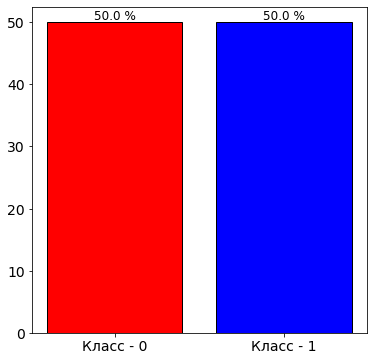

In [9]:
#Визуализация сбалансированного dataset
norm_y_data = y_data.value_counts(normalize=True)

per = 100
x = ['Класс - 0', 'Класс - 1']
y = [norm_y_data[0]*per,norm_y_data[1]*per]
fc = ['red', 'blue']

fig, ax = plt.subplots()
for idx in range(len(x)):
    plt.bar(x[idx], y[idx], fc=fc[idx], ec='black')
    plt.text(idx, norm_y_data[idx]*per, 
         f'{round(norm_y_data[idx]*per,2)} %',
         ha='center', va='bottom', fontsize=12)

fig.set_figwidth(6)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.show()

#Данные сбалансированны!

In [10]:
# Оценка признаков на bad/good

# 1.Missing Values
fs = FeatureSelector(data = x_data[feature_name[2:-1]], labels = y_data) # Не станем учитывать app_id, claim_fd
fs.identify_missing(missing_threshold=0) # 0 - означает, что мы полагаем удалить столбцы хотя бы с 1 пропуском
missing_features = fs.ops['missing']
if len(missing_features) == 0: 
    print("All features is full")
else: 
    missing_features
    
fs.missing_stats.head() # Таблица с долями пропуска

0 features with greater than 0.00 missing values.

All features is full


,missing_fraction
count_days_between_packets,0.0
count_periods_between_packets,0.0
count_payment_resourses_90d,0.0
count_verification,0.0
count_numbers,0.0


1 features with a single unique value.



,nunique
count_payments_2,97
count_modem,12
count_payments_1,95
sum_refill_part_2,6819
price_options_part_1,1329
calls_out_cnt_uniq_opps,278


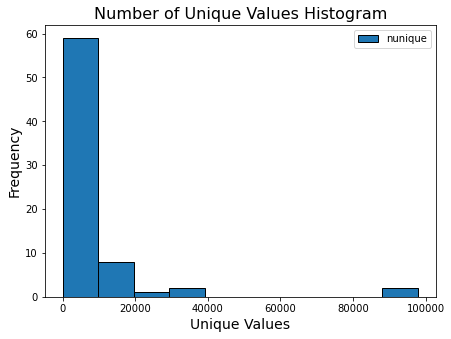

In [11]:
#2. Single Unique Value. Находим признаки с одним уникальным значением 

fs.identify_single_unique()
single_unique = fs.ops['single_unique']
if len(single_unique) == 0:
    print("There are not unique values")
else: single_unique
    
fs.plot_unique()
fs.unique_stats.sample(len(feature_name[-1])) #число уникальных значений на каждый признак

C:\Users\matveeviu\Projects\Yoto\f_selector\feature_selector\feature_selector.py:222: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record_collinear = record_collinear.append(temp_df, ignore_index = True)


4 features with a correlation magnitude greater than 0.90.

Сильно коррелируемые признаки:
 ['mean_days_between_packets', 'age_come_YOTA', 'sum_refill_part_2', 'sum_payments_part_2']


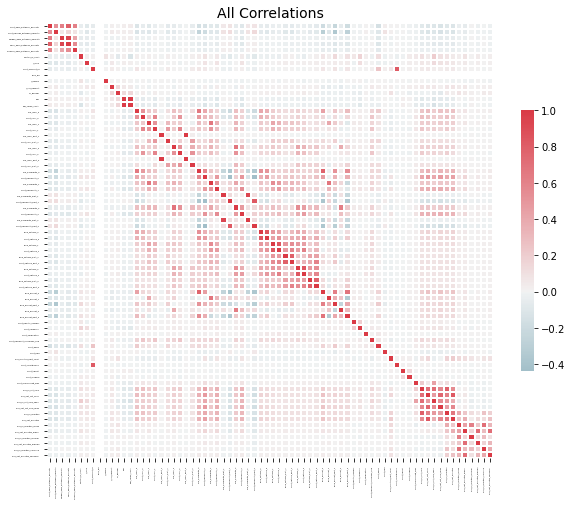

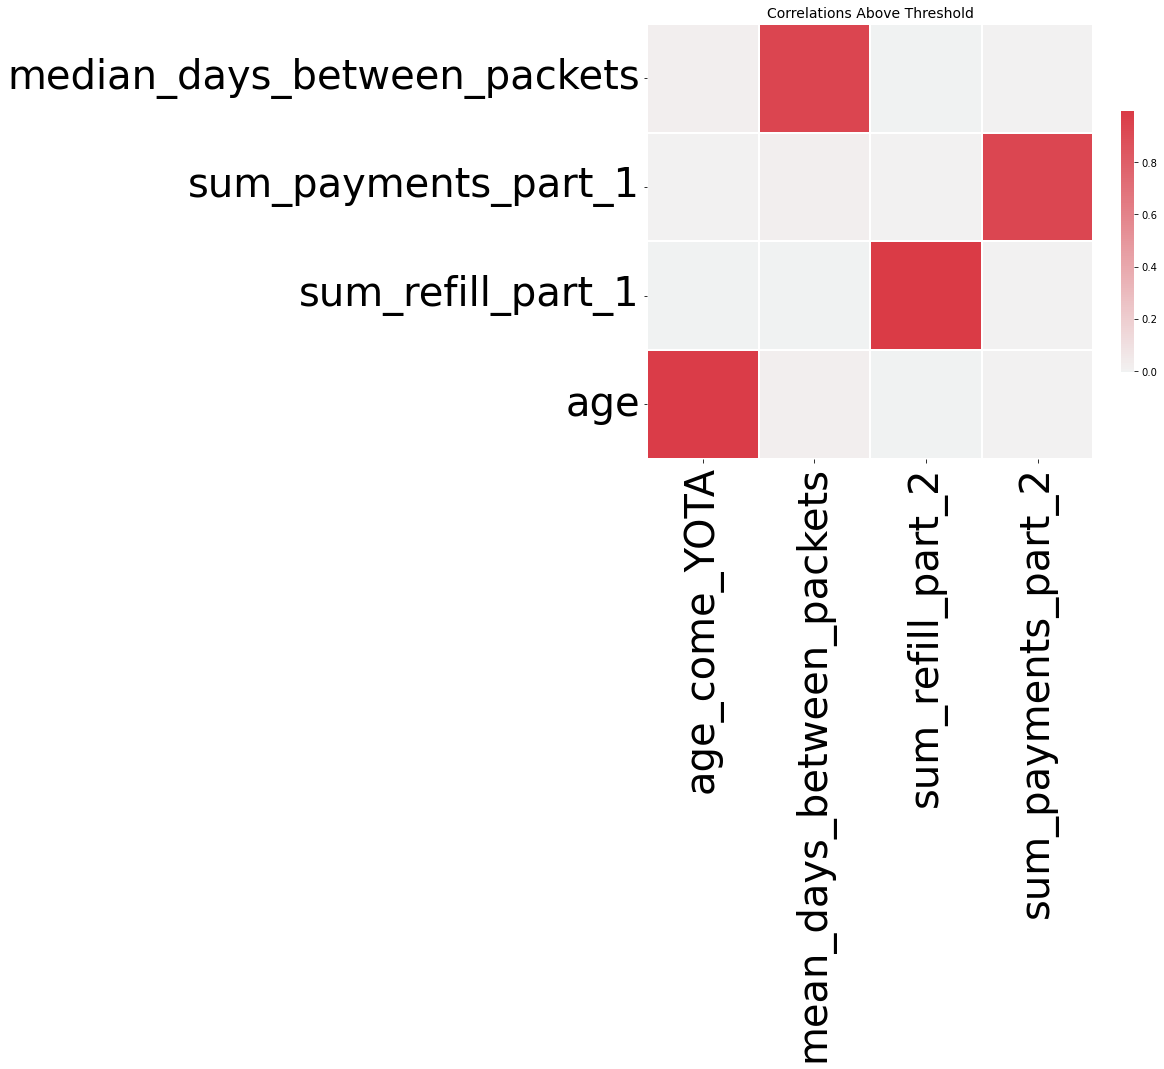

In [12]:
# 3. Collinear (highly correlated) Features. Строим матрицу корреляции. the Pearson correlation coefficient

fs.identify_collinear(correlation_threshold = 0.90) #установим значение 90% >
correlated_features = fs.ops['collinear']
print(f'Сильно коррелируемые признаки:\n {correlated_features}')
fs.plot_collinear(plot_all = True) # со всеми признаками
fs.plot_collinear(plot_all = False) # сильно корр. признаки

In [13]:
fs.record_collinear.head() #Найдем признаки, которые должны быть удалены 

,drop_feature,corr_feature,corr_value
0,mean_days_between_packets,median_days_between_packets,0.940117
1,age_come_YOTA,age,0.987902
2,sum_refill_part_2,sum_refill_part_1,0.996858
3,sum_payments_part_2,sum_payments_part_1,0.927457


In [14]:
#Сильно коррелируемые признаки
bad_corr_feature = list(fs.record_collinear['drop_feature'])
bad_corr_feature

['mean_days_between_packets',
 'age_come_YOTA',
 'sum_refill_part_2',
 'sum_payments_part_2']

In [15]:
# 4. Zero Importance Features (признаки 0 важности). Находим плохие признаки с помощью градиентного бустинга LightGBM library
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 15, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[436]	valid_0's auc: 0.852229	valid_0's binary_logloss: 0.476968
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[631]	valid_0's auc: 0.85624	valid_0's binary_logloss: 0.471396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	valid_0's auc: 0.857411	valid_0's binary_logloss: 0.469646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's auc: 0.855241	valid_0's binary_logloss: 0.472848
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's auc: 0.857335	valid_0's binary_logloss: 0.469782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	valid_0's auc: 0.859961	valid_0's binary_logloss: 0.46

In [16]:
one_hot_features = fs.one_hot_features  #saved features
base_features = fs.base_features        #original features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))
fs.data_all.head()

There are 72 original features
There are 0 one-hot features


,count_days_between_packets,count_periods_between_packets,median_days_between_packets,mean_days_between_packets,variance_days_between_packets,months_in_YOTA,is_mnp,count_account_id,have_pd,is_Russia,...,calls_in_cnt_uniq_opps,calls_out_cnt_uniq_opps,calls_in_minutes,calls_out_minutes,calls_in_minutes_mean,calls_out_minutes_mean,calls_in_minutes_median,calls_out_minutes_median,calls_in_minutes_variance,calls_out_minutes_variance
339595,0.0,0,0.0,0.000000,0.000000,47,0,5,1,1,...,19.0,23.0,136.0,670.0,2.43,4.16,1.0,3.0,11.631169,21.836258
343519,4.0,1,4.0,4.000000,0.000000,48,0,2,1,1,...,26.0,26.0,491.0,560.0,2.29,2.18,1.0,1.0,14.781471,16.264713
692181,0.0,0,0.0,0.000000,0.000000,17,1,2,1,1,...,31.0,24.0,147.0,256.0,1.48,1.65,1.0,1.0,1.987013,2.371345
487160,62.0,3,3.0,20.666667,990.333333,33,0,2,1,1,...,3.0,14.0,75.0,219.0,1.53,1.72,1.0,1.0,1.170918,3.042495
310503,2.0,1,2.0,2.000000,0.000000,48,0,3,1,1,...,45.0,47.0,797.0,408.0,1.76,2.09,1.0,1.0,5.798170,4.630611


In [17]:
# Выводим признаки с 0 важностью
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

['have_pd']

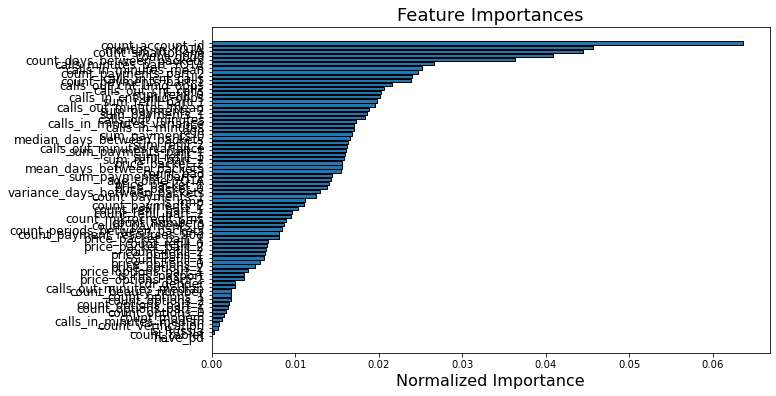

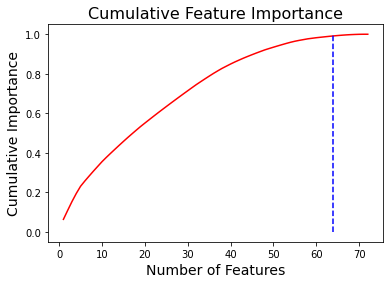

64 features required for 0.99 of cumulative importance


In [18]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 72)

In [19]:
fs.feature_importances.head()

,feature,importance,normalized_importance,cumulative_importance
0,count_account_id,793.800000,0.063616,0.063616
1,months_in_YOTA,569.733333,0.045659,0.109275
2,count_smartphone,554.600000,0.044446,0.153721
3,count_good,509.733333,0.040851,0.194572
4,count_days_between_packets,453.400000,0.036336,0.230908


In [20]:
#Удаляем сильно коррелируемые данные
for name in bad_corr_feature:
    feature_name.remove(name)

In [21]:
# Mutual Information
m_i_matrix = sklearn.feature_selection.mutual_info_classif(x_data[feature_name[2:-1]], 
                                                           y_data,
                                                           n_neighbors=3, 
                                                           copy=True, 
                                                           random_state=None)
mutual_information_dict = {}
for idx,key in enumerate(feature_name[2:-1]):
    mutual_information_dict[key] = m_i_matrix[idx]

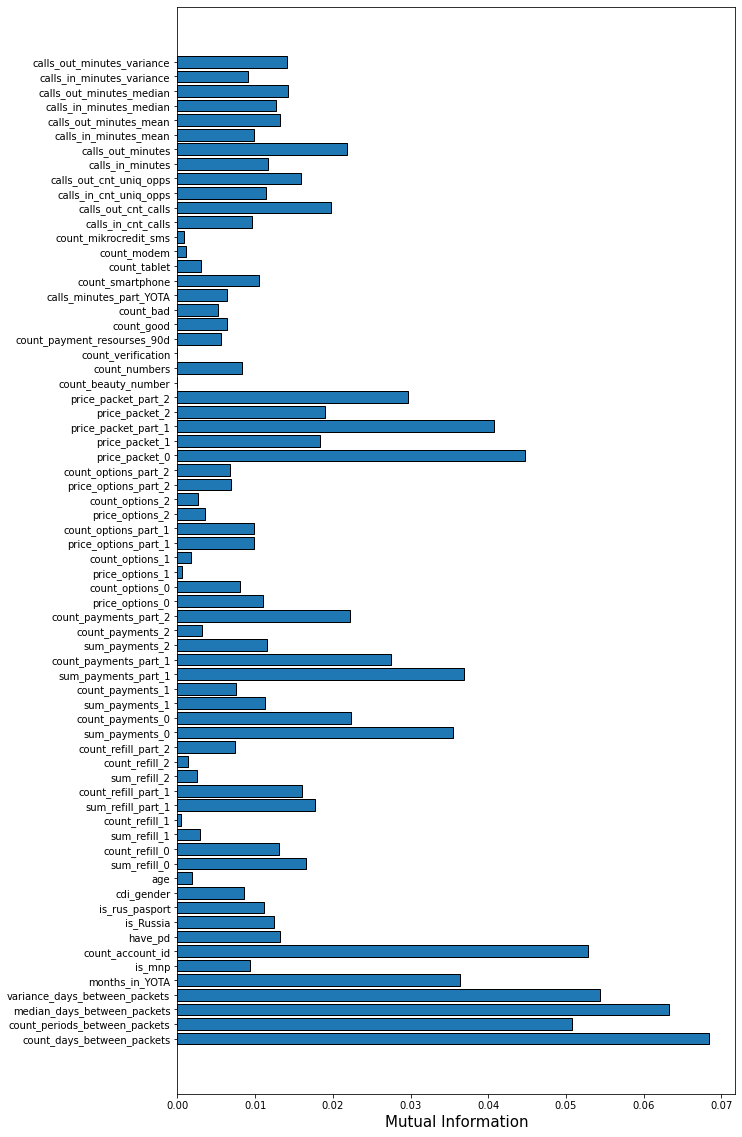

Top 11 features: ['count_days_between_packets', 'median_days_between_packets', 'variance_days_between_packets', 'count_account_id', 'count_periods_between_packets', 'price_packet_0', 'price_packet_part_1', 'sum_payments_part_1', 'months_in_YOTA', 'sum_payments_0', 'price_packet_part_2']


In [22]:
# Визуализация значений MI
mutual_information_value = [itm for key,itm in mutual_information_dict.items()]
mutual_information_key = [key for key,itm in mutual_information_dict.items()]

fig, ax = plt.subplots()
plt.barh(list(mutual_information_dict.keys()), mutual_information_value, ec='black')
fig.set_figwidth(10)    #  ширина Figure
fig.set_figheight(20)    #  высота Figure
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(10)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Mutual Information')
plt.show()

#The most important features. TOP-11
top_11_feature_name = []

def max_search_top(mutual_information_value, mutual_information_key):
    
    max_value = max(mutual_information_value)
    idx = mutual_information_value.index(max_value)
    top_11_feature_name.append(mutual_information_key[idx])
    
    mutual_information_value.remove(max_value)
    mutual_information_key.remove(mutual_information_key[idx])
    
    if len(top_11_feature_name) == 11:
        return top_11_feature_name
    else:
        max_search_top(mutual_information_value, mutual_information_key)

    
max_search_top(mutual_information_value, mutual_information_key)

# top 11 features
print(f'Top 11 features: {top_11_feature_name}')

In [23]:
bad_mi_dict = []
good_mi_dict = []
for key,value in mutual_information_dict.items():
    #Отбираем признаки MI с тыс. долями
    if value < 0.01: bad_mi_dict.append(key)
    else: good_mi_dict.append(key)
        
all_bad_features = zero_importance_features + bad_mi_dict
all_bad_features = list(set(all_bad_features))

bad_x_data = x_data[all_bad_features]
good_feature_name = list(set(feature_name[2:-1]) - set(all_bad_features))
good_x_data = x_data[good_feature_name]

In [24]:
all_bad_features = zero_importance_features + bad_mi_dict
all_bad_features = list(set(all_bad_features))

C:\Users\matveeviu\.conda\envs\exponenta\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


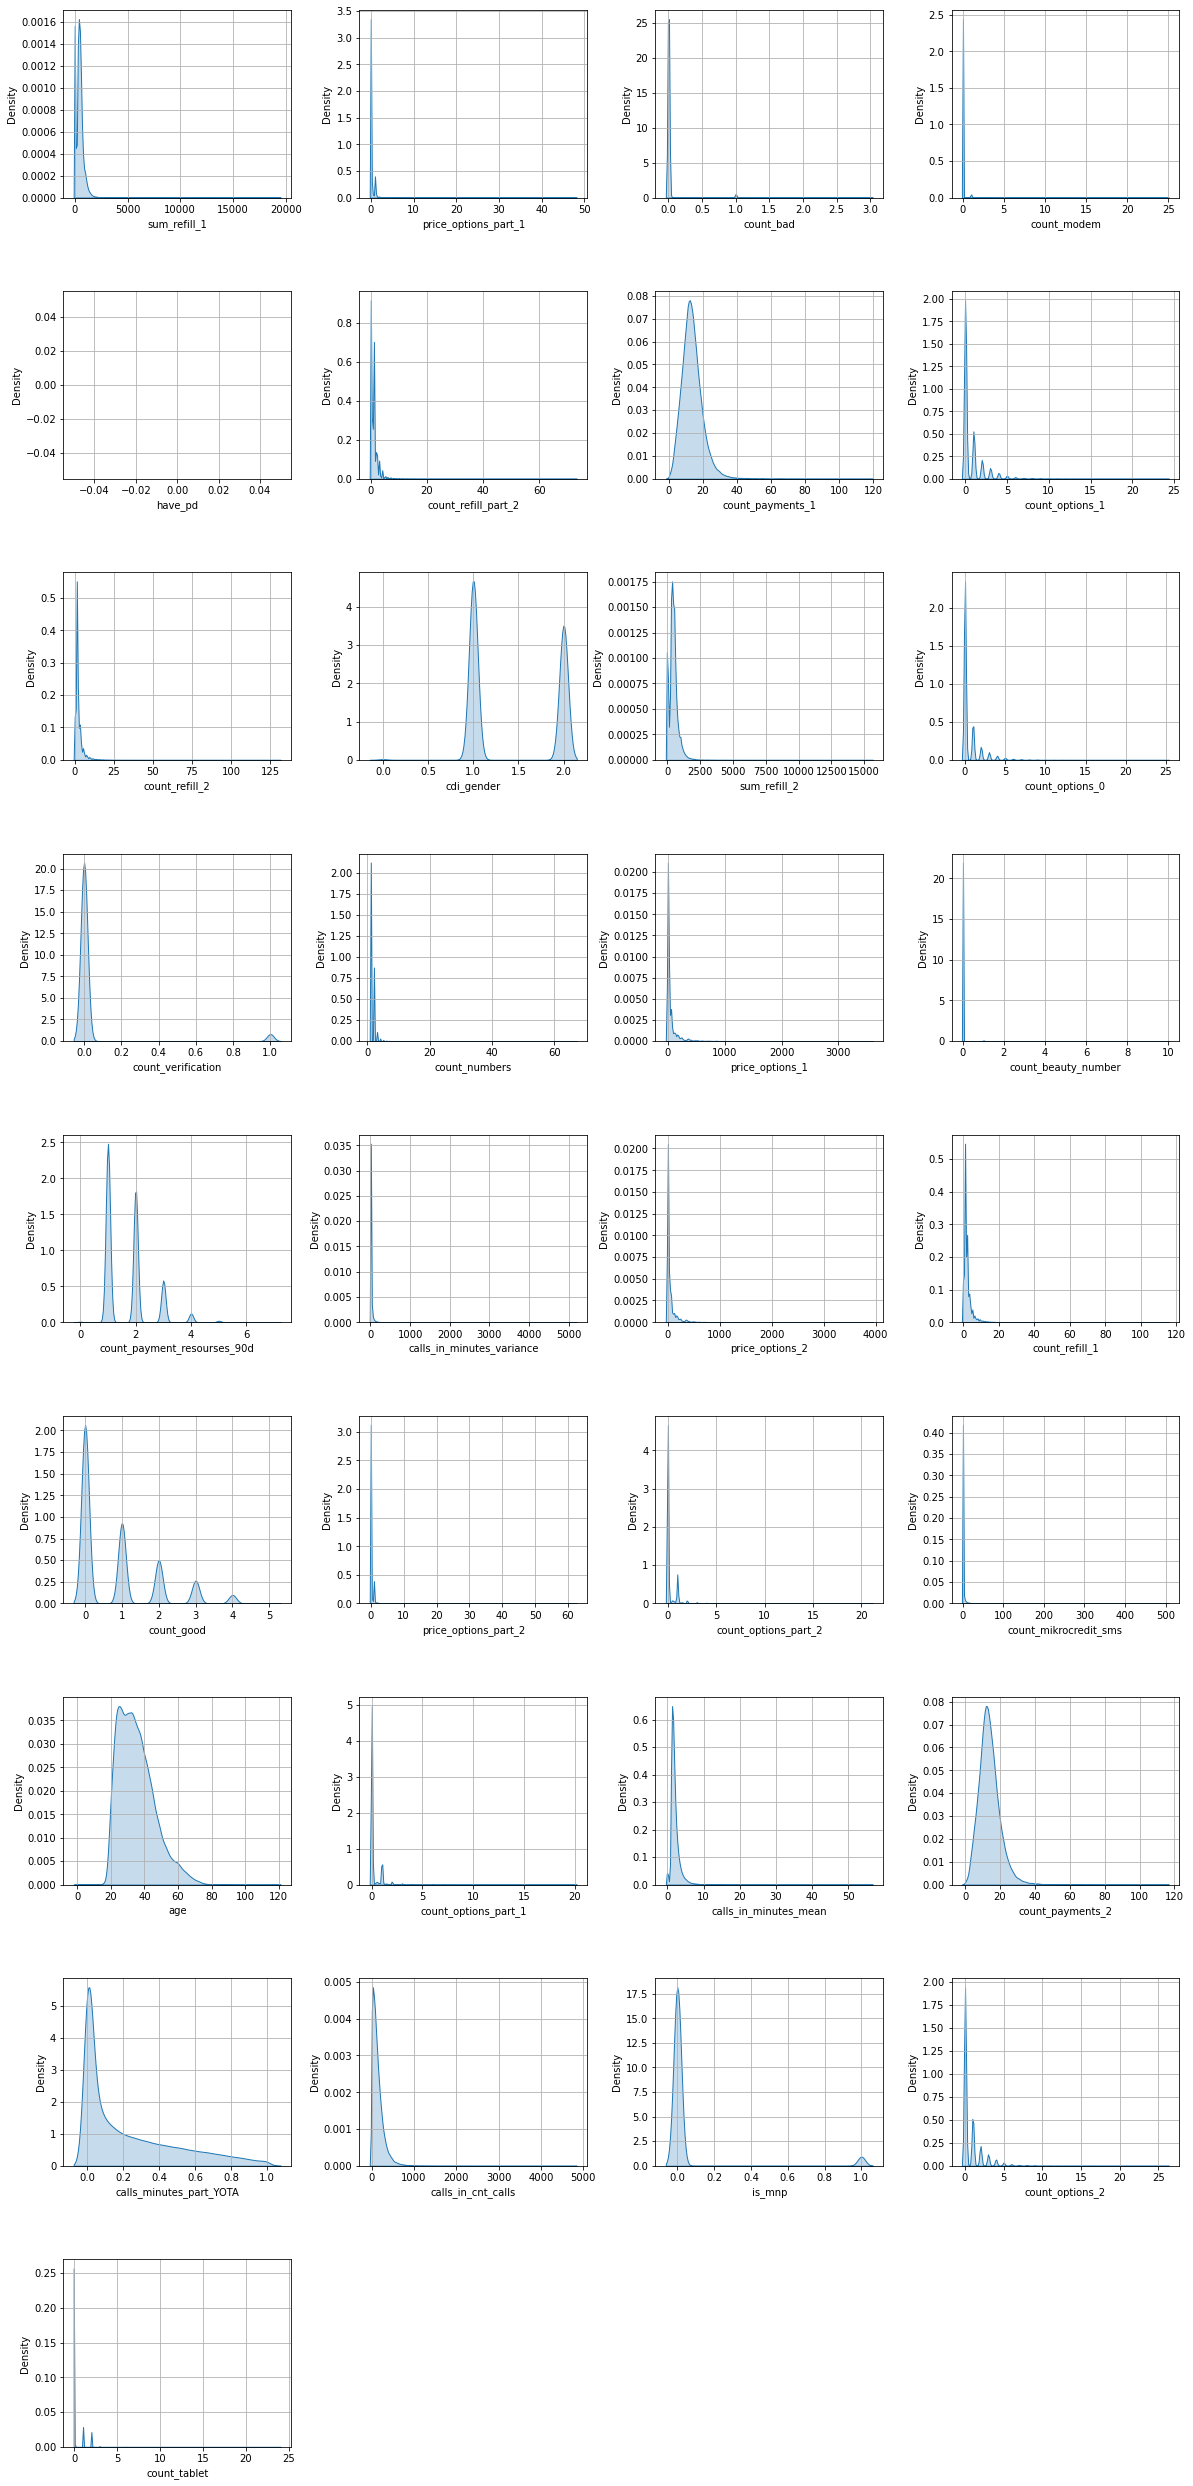

In [25]:
#Распределения плохих для признаков
wspace = 0.3
hspace = 0.5
nfont = 10
wsize = 20
hsize = 50
idx = 1

for idx,name in enumerate(all_bad_features):
    plt.subplot(10, 4, idx+1)
    sns_plot = sns.kdeplot(bad_x_data[name], shade=True)
    sns_plot.set_xlabel(name, fontsize = nfont)
    sns_plot.set_ylabel("Density", fontsize = nfont)
    sns_plot.tick_params(labelsize=nfont)
    fig = sns_plot.get_figure()
    fig.set_size_inches(wsize,hsize)
    plt.grid()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

In [26]:
bad_x_data = x_data[all_bad_features]
good_feature_name = list(set(feature_name[2:-1]) - set(all_bad_features))
good_x_data = x_data[good_feature_name]

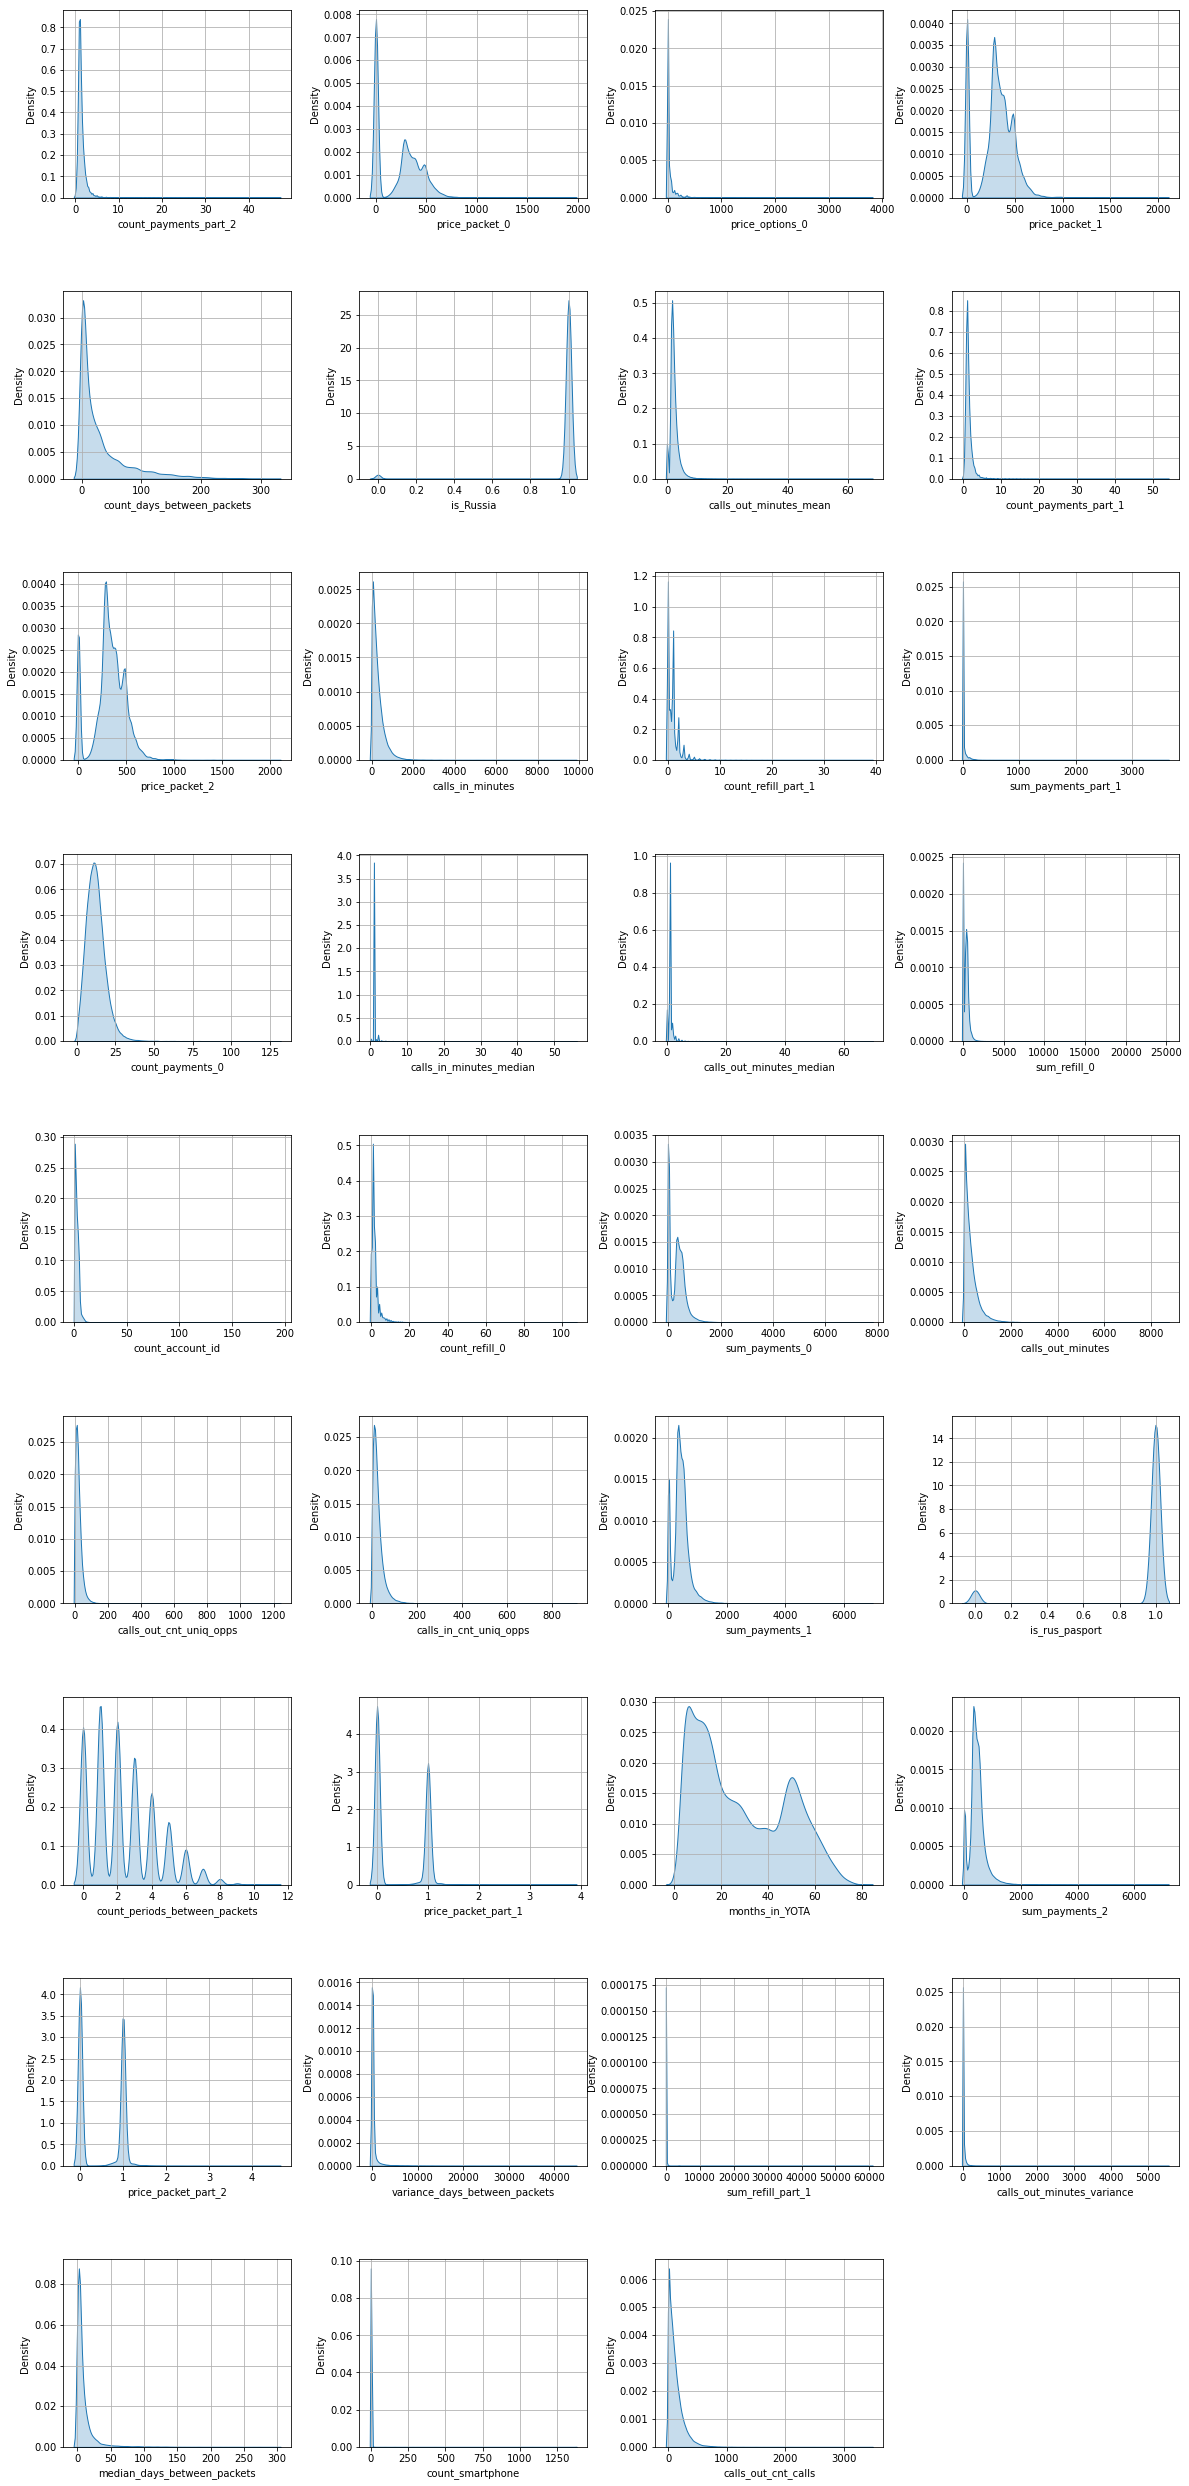

In [27]:
#Распределения для хороших признаков
wspace = 0.3
hspace = 0.5
nfont = 10
wsize = 20
hsize = 50
idx = 1

for idx,name in enumerate(good_feature_name):
    plt.subplot(10, 4, idx+1)
    sns_plot = sns.kdeplot(good_x_data[name], shade=True)
    sns_plot.set_xlabel(name, fontsize = nfont)
    sns_plot.set_ylabel("Density", fontsize = nfont)
    sns_plot.tick_params(labelsize=nfont)
    fig = sns_plot.get_figure()
    fig.set_size_inches(wsize,hsize)
    plt.grid()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

Вектор объясненной дисперсии: [0.136 0.203 0.255 0.301 0.341 0.376 0.41  0.438 0.465 0.491 0.513 0.534
 0.553 0.571 0.589 0.607 0.624 0.641 0.657 0.673 0.688 0.702 0.717 0.732
 0.746 0.76  0.773 0.786 0.799 0.812 0.825 0.837 0.849 0.86  0.872 0.882
 0.893 0.902 0.91  0.918 0.926 0.933 0.939 0.945 0.951 0.956 0.96  0.964
 0.968 0.971 0.974 0.977 0.98  0.983 0.985 0.987 0.989 0.991 0.992 0.994
 0.995 0.996 0.997 0.998 0.999 0.999 1.    1.   ]


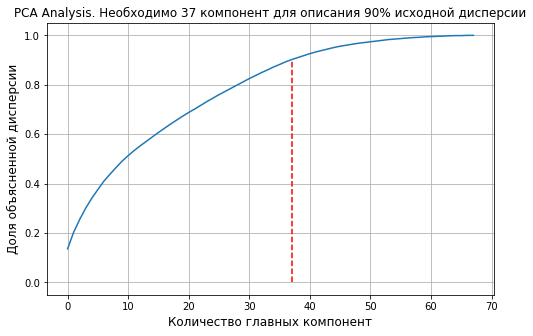

In [28]:
# Алгоритм для снижения размерности dataset. PCA

n_comp=68
X = StandardScaler().fit_transform(x_data[feature_name[2:-1]])
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(X)
explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)
print(f'Вектор объясненной дисперсии: {explained_variance}')
componenta = list(explained_variance).index(0.902)

fig, ax = plt.subplots()
plt.plot(np.arange(n_comp), explained_variance, ls = '-')
ax.vlines(componenta, 0, 0.902, linestyles='dashed', colors='red')
plt.xlabel('Количество главных компонент', fontsize=12)
plt.ylabel('Доля объясненной дисперсии', fontsize=12)
plt.title(f'PCA Analysis. Необходимо {componenta} компонент для описания 90% исходной дисперсии', fontsize=12)
fig.set_figwidth(8)    #  ширина Figure
fig.set_figheight(5)    #  высота Figure
plt.grid()

In [29]:
# Рассчитанное кол-во компонент
n_comp=37
X = StandardScaler().fit_transform(x_data[feature_name[2:-1]])
pca = PCA(n_components=n_comp, svd_solver='full')
pca_rediced_data = pca.fit_transform(X)
pca_rediced_data.shape

(114868, 37)

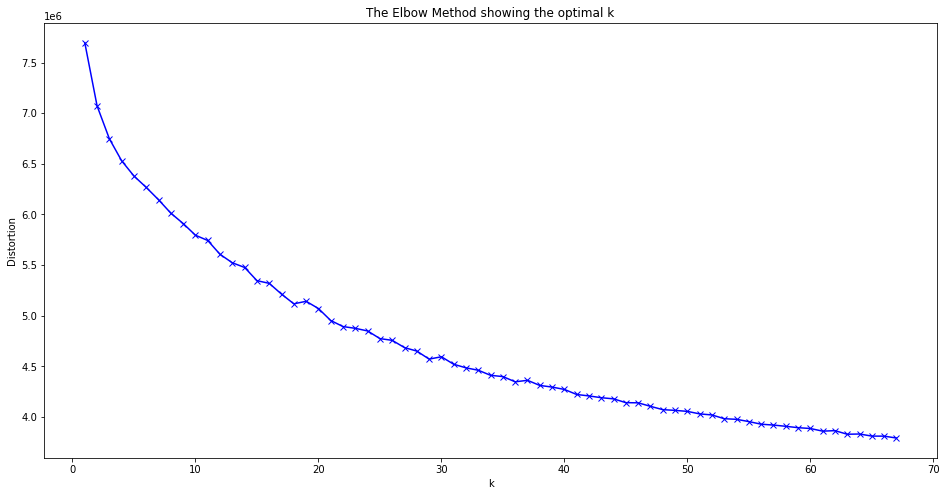

In [30]:
# Определяем число кластеров
from sklearn.cluster import KMeans

X = StandardScaler().fit_transform(x_data[feature_name[2:-1]])
distortions = []
K = range(1,len(feature_name[2:-1]))
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=101).fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Примерно необходимо 20 кластеров. Оличается от предыдущих тестов, где соотношение bad/good = 39/33

In [31]:
#Предварительная подготовка данных для обучения           
cls_obj = Data_Preparation(x_data, y_data, feature_name[2:-1])
x_train, x_test, y_train, y_test = cls_obj.run_up()

In [32]:
#Создадим объект для выбора лучшего классификатора из: log_reg, svc, decision tree  
classificator = CreditScoreModel(x_train, y_train)

In [33]:
#log_reg algoritm
lg_reg_classificator = classificator.log_reg()
y_pred_lg_reg = lg_reg_classificator.predict(x_test)
score_lg_reg = lg_reg_classificator.score(x_test, y_test)

In [ ]:
#svc algoritm
svc_classificator = classificator.svc()
y_pred_svc = svc_classificator.predict(x_test)
score_svc = svc_classificator.score(x_test, y_test)

In [35]:
#decision_tree algoritm
dt_classificator = classificator.decision_tree()
y_pred_dt = dt_classificator.predict(x_test)
score_dt = dt_classificator.score(x_test, y_test)

In [36]:
print(f'F1-Score (Accuracy) for LogRegression:', round(f1_score(y_test, y_pred_lg_reg, average='binary')*100, 3), '%')
print(f'F1-Score (Accuracy) for SVC:', {round(f1_score(y_test, y_pred_svc, average='binary')*100, 3)}, '%')
print(f'F1-Score (Accuracy) for Decision Tree', {round(f1_score(y_test, y_pred_dt, average='binary')*100, 3)}, '%')

F1-Score (Accuracy) for LogRegression: 73.8 %
F1-Score (Accuracy) for SVC: {63.061} %
F1-Score (Accuracy) for Decision Tree {68.15} %


C:\Users\matveeviu\.conda\envs\exponenta\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


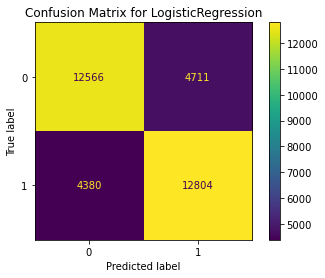

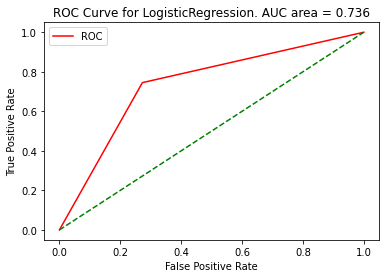

C:\Users\matveeviu\.conda\envs\exponenta\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


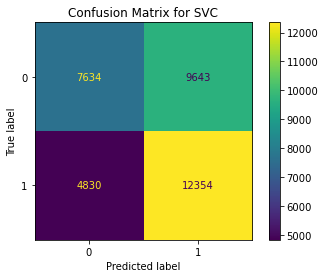

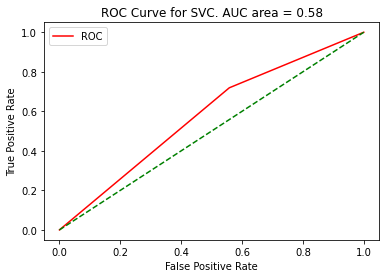

C:\Users\matveeviu\.conda\envs\exponenta\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


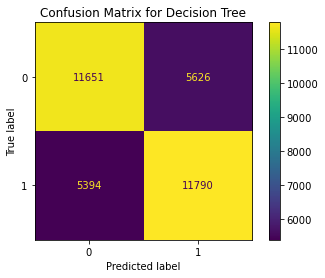

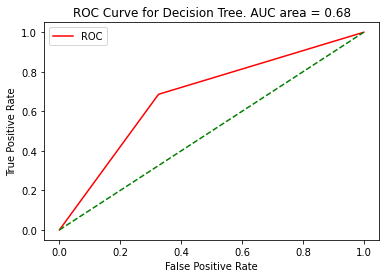

In [37]:
#Confusion Matrix, ROC-analysis
roc_metric = ROC_metric(x_test, y_test)
roc_metric.roc_lg(lg_reg_classificator, y_pred_lg_reg)
roc_metric.roc_svc(svc_classificator, y_pred_svc)
roc_metric.roc_dt(dt_classificator, y_pred_dt)

In [38]:
#Подготвка данных, обучение на ТОП-11 признаков
cls_top_obj = Data_Preparation(x_data, y_data, top_11_feature_name) #Объект для классификации
x_train, x_test, y_train, y_test = cls_top_obj.run_up()
top_classificator = CreditScoreModel(x_train, y_train)

In [39]:
#log_reg algoritm _ top_11_feature_name
lg_reg_classificator = top_classificator.log_reg()
y_pred_lg_reg = lg_reg_classificator.predict(x_test)
score_lg_reg = lg_reg_classificator.score(x_test, y_test)

In [ ]:
#svc algoritm _ top_11_feature_name
svc_classificator = top_classificator.svc()
y_pred_svc = svc_classificator.predict(x_test)
score_svc = svc_classificator.score(x_test, y_test)

In [41]:
#decision_tree algoritm _ top_11_feature_name
dt_classificator = top_classificator.decision_tree()
y_pred_dt = dt_classificator.predict(x_test)
score_dt = dt_classificator.score(x_test, y_test)

C:\Users\matveeviu\.conda\envs\exponenta\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


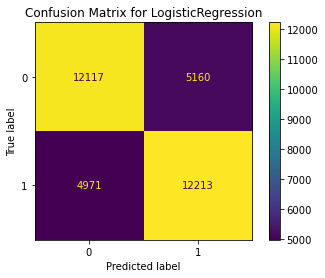

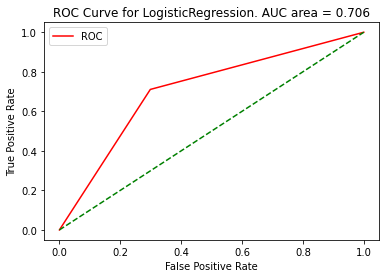

C:\Users\matveeviu\.conda\envs\exponenta\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


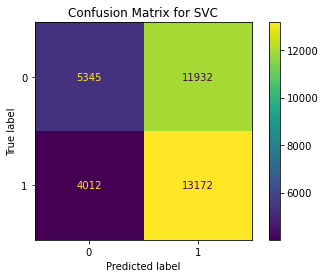

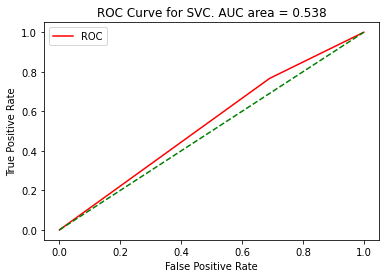

C:\Users\matveeviu\.conda\envs\exponenta\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


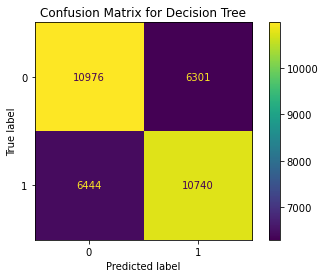

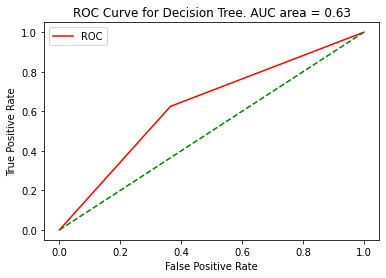

In [42]:
#Confusion Matrix, ROC-analysis на ТОП-11 признаков
roc_metric = ROC_metric(x_test, y_test)
roc_metric.roc_lg(lg_reg_classificator, y_pred_lg_reg)
roc_metric.roc_svc(svc_classificator, y_pred_svc)
roc_metric.roc_dt(dt_classificator, y_pred_dt)

In [43]:
#на ТОП-11 признаков
print(f'F1-Score (Accuracy) for LogRegression:', round(f1_score(y_test, y_pred_lg_reg, average='binary')*100, 3), '%')
print(f'F1-Score (Accuracy) for SVC:', {round(f1_score(y_test, y_pred_svc, average='binary')*100, 3)}, '%')
print(f'F1-Score (Accuracy) for Decision Tree', {round(f1_score(y_test, y_pred_dt, average='binary')*100, 3)}, '%')

F1-Score (Accuracy) for LogRegression: 70.683 %
F1-Score (Accuracy) for SVC: {62.297} %
F1-Score (Accuracy) for Decision Tree {62.761} %


In [44]:
# Regression task
regression_data = x_data.assign(y_data=y_data)
timeline = list(regression_data['claim_fd'])
n = 0
n_zero = 0
n_ones = 0

list_data = Counter(map(lambda x: x,  timeline))
print(list_data)
list_data_ = list(list_data)
time_data = {}

for t_data in list_data_:
    n_ones += regression_data.loc[(regression_data['claim_fd'] == t_data) & (regression_data['y_data'] == 1)].shape[0]
    n_zero += regression_data.loc[(regression_data['claim_fd'] == t_data) & (regression_data['y_data'] == 0)].shape[0]
    time_data[t_data] = [n_zero, n_ones]
    
for itm in time_data.items():
    sum_ = itm[1][0]+itm[1][1]
    print(f'За {itm[0]} - доля is_bad = 0: {round(itm[1][0]/sum_, 3)},\t доля is_bad = 1: {round(itm[1][1]/sum_, 3)}')

Counter({20211: 26156, 202012: 24260, 202010: 23198, 202011: 23114, 20212: 13069, 20209: 5071})
За 202012 - доля is_bad = 0: 0.509,	 доля is_bad = 1: 0.491
За 20211 - доля is_bad = 0: 0.496,	 доля is_bad = 1: 0.504
За 202010 - доля is_bad = 0: 0.497,	 доля is_bad = 1: 0.503
За 202011 - доля is_bad = 0: 0.496,	 доля is_bad = 1: 0.504
За 20212 - доля is_bad = 0: 0.499,	 доля is_bad = 1: 0.501
За 20209 - доля is_bad = 0: 0.5,	 доля is_bad = 1: 0.5


In [45]:
X = [[list_data_[idx]] for idx in range(len(list_data_))]
y = [list_data[value] for value in list_data]
regr = LinearRegression().fit(X, y)
regr.fit(X, y)

LinearRegression()

In [46]:
# Предсказание кол-ва is_bad на 2021 год на Март 
print(f'Количество is_bad в новом месяце: {int(regr.predict([[20213]]))}')

Количество is_bad в новом месяце: 14765
